Welcome to this notebook! In this notebook, we’re going to build a book recommendation system using the and k-Nearest Neighbors (k-NN) algorithm.

k-Nearest Neighbors
The k-NN algorithm is a type of instance-based learning, or lazy learning, where the function is only approximated locally, that is by finding the K nearest points in the training dataset and then using respective class to predict the class or value of a new data point.

As we see, max value for "Age" is 244, which is likely a mistake, so let us handle such values by 
replacing them with average age, considering only ages below 100

In [13]:
average_age = users['Age'][users['Age'] <= 100].mean()

# Replace values greater than 110 with the average age
users['Age'] = users['Age'].mask(users['Age'] > 100, average_age)

Now, let us plot user age distribution:
A histogram of the ‘Age’ column in the ‘Users’ dataset to understand the age distribution of the users.

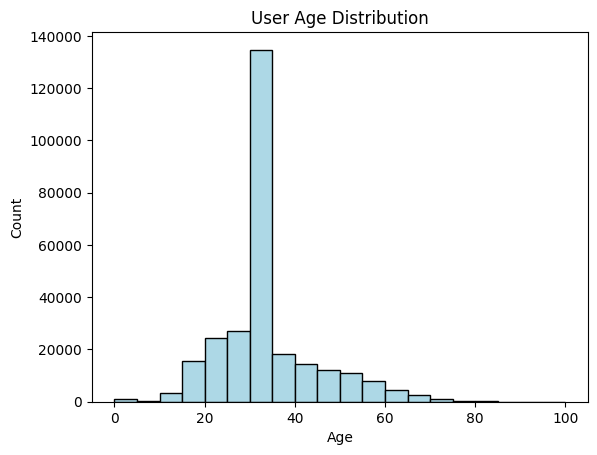

In [14]:
import matplotlib.pyplot as plt

plt.hist(users['Age'], bins=20, color='lightblue', edgecolor='black')
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Next, let us plot location distribution: A bar chart of the top 10 countries in the ‘Location’ column to see where most of your users are from.

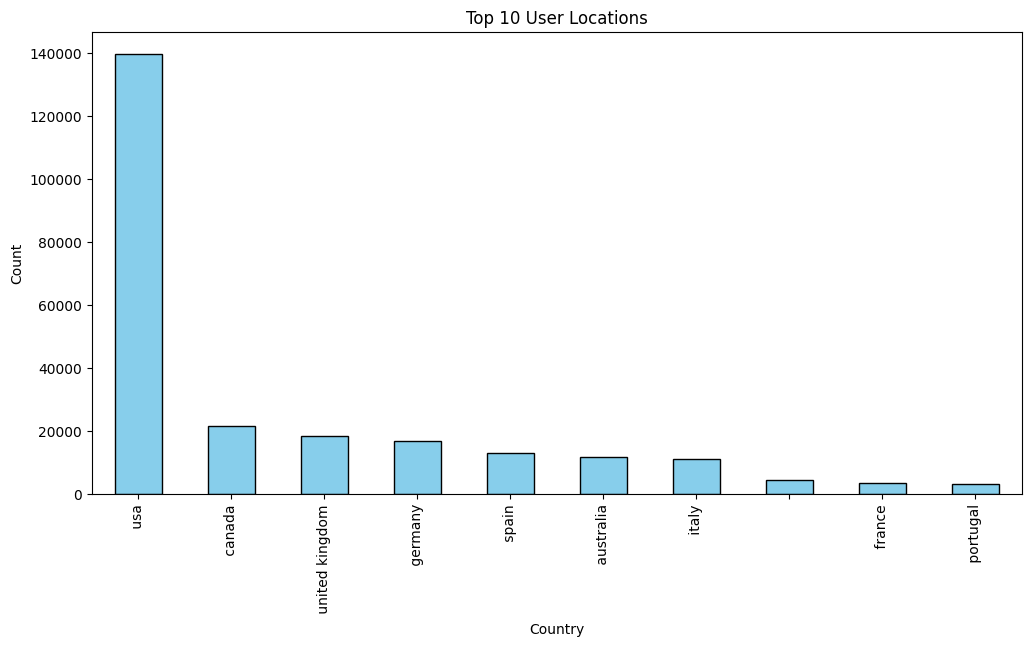

In [15]:
top_countries = users['Location'].value_counts().head(10)

plt.figure(figsize=(12,6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 User Locations')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

Next, let us plot a histogram of the ‘Book-Rating’ column in the ‘Ratings’ dataset to understand the distribution of ratings.

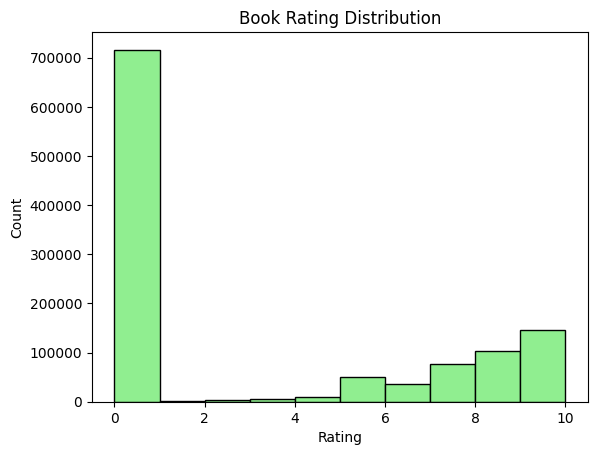

In [16]:
plt.hist(ratings['Book-Rating'],bins=10,color='lightgreen',edgecolor='black')
plt.title("Book Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


We can see that majority of ratings are implicit

Next, let us visualize books per user and ratings per book, it might be interesting to see how many books each user has rated and how many ratings each book has received.

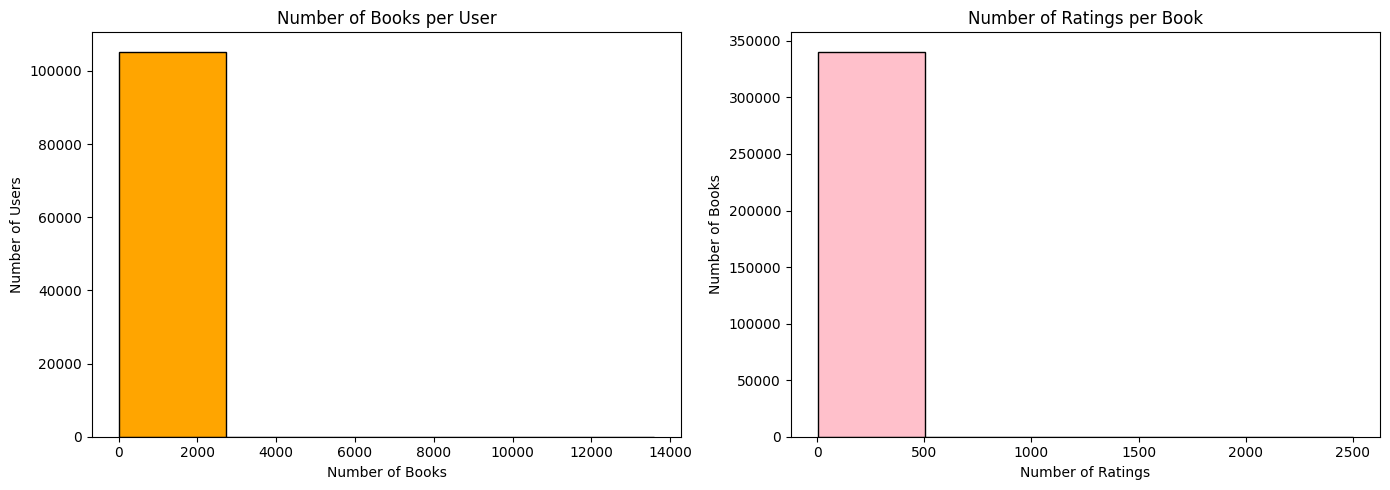

In [17]:
books_per_user = ratings.groupby('User-ID')['ISBN'].count()
ratings_per_book = ratings.groupby('ISBN')['Book-Rating'].count()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(books_per_user, bins=5, color='orange', edgecolor='black')
ax[0].set_title('Number of Books per User')
ax[0].set_xlabel('Number of Books')
ax[0].set_ylabel('Number of Users')

ax[1].hist(ratings_per_book, bins=5, color='pink', edgecolor='black')
ax[1].set_title('Number of Ratings per Book')
ax[1].set_xlabel('Number of Ratings')
ax[1].set_ylabel('Number of Books')

plt.tight_layout()
plt.show()


From this point, let's begin to prepare data for our future model

In [18]:
# Merge the dataframes
data = pd.merge(users, ratings, on='User-ID')
data = pd.merge(data, books, on='ISBN')


In [19]:
data.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,usa,18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,canada,32.0,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400,canada,49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676,n/a,32.0,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385,canada,32.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Upcoming cells will apply the filtering to the data:

Then, we create the pivot table and fit the model using the filtered training data:

In [20]:
# Filter users who have rated at least 50 books
active_users = data.groupby('User-ID').filter(lambda x: len(x) >= 50)

# Filter books that have been rated by at least 100 users
popular_books = data.groupby('ISBN').filter(lambda x: len(x) >= 100)


filtered_data = pd.merge(active_users, popular_books)

In [21]:
# Create a pivot table
pivot_table = filtered_data.pivot(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)

In [29]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

data_matrix = csr_matrix(pivot_table.values)

# Fit the nearest neighbors model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(data_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

Let us check user ids, we will use one of those values to recommend books specific user

In [30]:
pivot_table.columns

Index([   243,    254,    507,    638,    643,    741,    882,    929,   1025,
         1211,
       ...
       277928, 277965, 278026, 278137, 278144, 278188, 278418, 278582, 278633,
       278843],
      dtype='int64', name='User-ID', length=2924)

And define small function which can be used to make recommendations.

In [31]:
def recommend_books(model, matrix, user_id, N):
    # Get the index of the user
    user_idx = pivot_table.columns.tolist().index(user_id)

    # Get the nearest neighbors (excluding the user itself)
    distances, indices = model.kneighbors(matrix[user_idx], n_neighbors=N+1)

    # Get the user ids of the nearest neighbors
    nearest_users = [pivot_table.columns[i] for i in indices.flatten()][1:]

    # Get the books rated highly by the nearest users (corrected part)
    recommended_books = data[data['User-ID'].isin(nearest_users)] \
                           .sort_values('Book-Rating', ascending=False) \
                           .iloc[:N, :]['ISBN'].tolist()

    return recommended_books


In [37]:
recommendations = recommend_books(model_knn, data_matrix, user_id=254, N=5)
print(recommendations)

['015602943X', '0216927781', '0745917437', '0842329129', '0696217120']


So, our knn model recommended those books to our user with ID = '254'

Finally, let us save the model

In [41]:
import pickle

# Save the KNN model
with open('model_knn.pkl', 'wb') as f:
    pickle.dump(model_knn, f)



### To conclude,

we have successfully built a book recommendation system using the k-Nearest Neighbors (k-NN)
algorithm.

Our recommendation system takes a user_id as input and provides a list of recommended books as output. 
The system was implemented using a pivot table to create a user-item matrix, which was then converted into a sparse matrix to fit the k-NN model. The model was trained to find the nearest neighbors using cosine similarity.

Overall, the k-NN based recommendation system provides a simple yet effective way to provide personalized recommendations to users.